# Setting up the Data

## Setting up Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
# raw data location
data_path = "rawDataSample.bin"

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(2)
torch.manual_seed(0)

## Loading the data 

In [4]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [5]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

In [6]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# Analysing 50000 frames; from 699958 to 750055
# A

## Setting up the data

In [7]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(95240, 51)


## Defining the Model

In [8]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [9]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [10]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Loading Models

In [11]:
gan_1 = torch.load('models/visapy/gan_12.pt', map_location=lambda storage, loc: storage)
gan_2 = torch.load('models/visapy/gan_10.pt', map_location=lambda storage, loc: storage)
gan_3 = torch.load('models/visapy/gan_8.pt', map_location=lambda storage, loc: storage)
gan_4 = torch.load('models/visapy/gan_6.pt', map_location=lambda storage, loc: storage)
gan_5 = torch.load('models/visapy/gan_4.pt', map_location=lambda storage, loc: storage)
gan_6 = torch.load('models/visapy/gan_2.pt', map_location=lambda storage, loc: storage)

## Testing 12-dim embedding

In [12]:
enc_12 = np.zeros([total_sigs, 12])
out_12 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_1.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_12[i, :] = enc[:]
    out_12[i, :] = o[:]

## Testing 10-dim embedding

In [13]:
enc_10 = np.zeros([total_sigs, 10])
out_10 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_2.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_10[i, :] = enc[:]
    out_10[i, :] = o[:]

## Testing 8-dim embedding

In [14]:
enc_8 = np.zeros([total_sigs, 8])
out_8 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_3.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_8[i, :] = enc[:]
    out_8[i, :] = o[:]

## Testing 6-dim embedding

In [15]:
enc_6 = np.zeros([total_sigs, 6])
out_6 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_4.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_6[i, :] = enc[:]
    out_6[i, :] = o[:]

## Testing 4-dim embedding

In [16]:
enc_4 = np.zeros([total_sigs, 4])
out_4 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_5.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_4[i, :] = enc[:]
    out_4[i, :] = o[:]

## Testing 2-dim embedding

In [17]:
enc_2 = np.zeros([total_sigs, 2])
out_2 = np.zeros([total_sigs, 51])

for i in range(electrode_data.shape[0]):
    data = electrode_data[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o = gan_6.forward(data)
    o = (o.data).cpu().numpy()
    enc = (enc.data).cpu().numpy()
    
    enc_2[i, :] = enc[:]
    out_2[i, :] = o[:]

In [18]:
def find_mse(original, recons, params='all'):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        mse.append(np.mean(se))
    mse = np.array(mse)
  
    if params == 'median':
        return np.median(mse), np.std(mse)
    elif params == 'limits':
        return np.amax(mse), np.amin(mse)
    else:
        return np.median(mse), np.std(mse), np.amax(mse), np.amin(mse)

In [19]:
print(find_mse(electrode_data, out_12))

(73.72266171201855, 134.827027445543, 4638.328861102783, 5.287789346760519)


In [20]:
print(find_mse(electrode_data, out_10))

(77.77463164485903, 146.53191598719084, 4770.217076332394, 5.063403250522503)


In [21]:
print(find_mse(electrode_data, out_8))

(79.24382000441763, 132.88501851296564, 4293.8781850607575, 5.495775227842142)


In [22]:
print(find_mse(electrode_data, out_6))

(95.78701430699681, 176.69224981539764, 5745.730775178043, 6.436768487441996)


In [23]:
print(find_mse(electrode_data, out_4))

(147.29954470914998, 222.65865616902303, 7181.577545485476, 9.60394166924668)


In [24]:
print(find_mse(electrode_data, out_2))

(253.537549770469, 297.709862509822, 7543.108608259913, 13.254521718053484)


In [25]:
from herdingspikes.hs2 import HSClustering
C = HSClustering(H)

def gen_features(enc_data, pca=False):
    C.ShapePCA(pca_ncomponents=2, pca_whiten=True)
    if pca is False:
        print('Updating features from encoded data')
        C.features = enc_data
#print(C.features.shape)

In [26]:
def get_cluster(alpha):
    C.CombinedClustering(alpha=alpha, bandwidth=5., bin_seeding=False, n_jobs=-1)

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(111)
    C.PlotAll(invert=True, s=1, ax=ax, max_show=100000, show_labels=False)
    plt.title("MeanShift, no bin seeding");

In [27]:
gen_features(enc_2)

Fitting PCA using 95240 spikes...
...projecting...
...done
Updating features from encoded data


Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   36.8s remaining:  1.8min
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   38.3s remaining:    7.7s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   38.8s finished


Number of estimated units: 21754


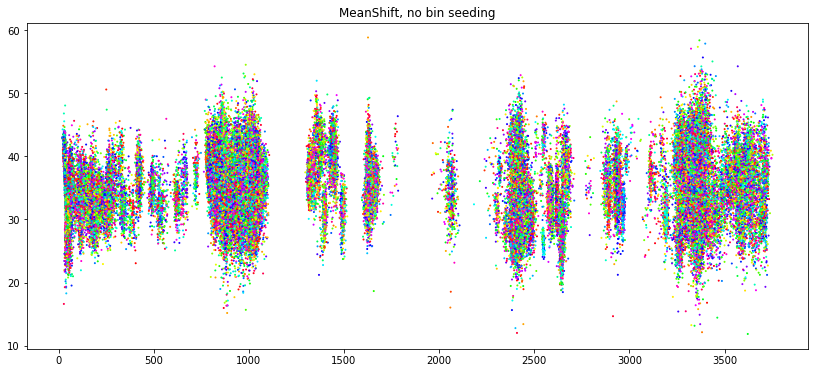

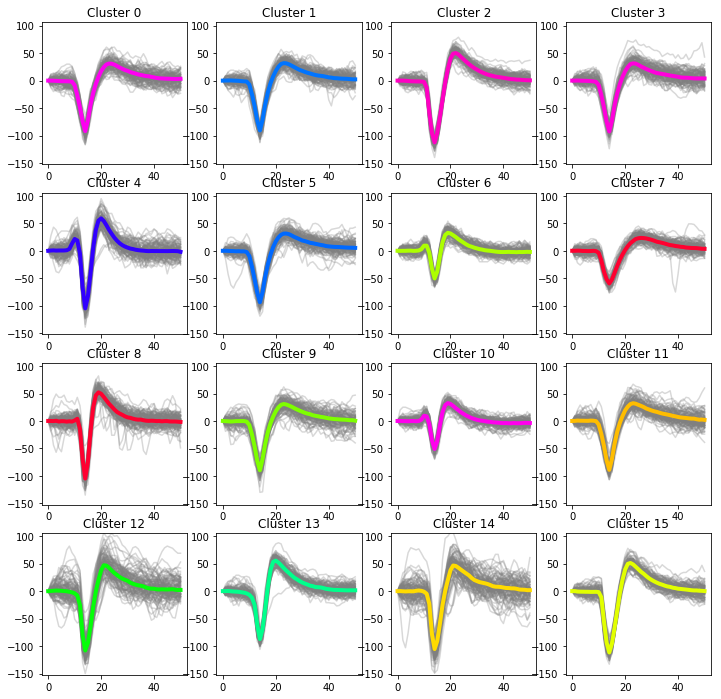

In [28]:
get_cluster(0.25)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   14.9s remaining:   44.8s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:   15.9s remaining:    3.2s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   16.1s finished


Number of estimated units: 42303


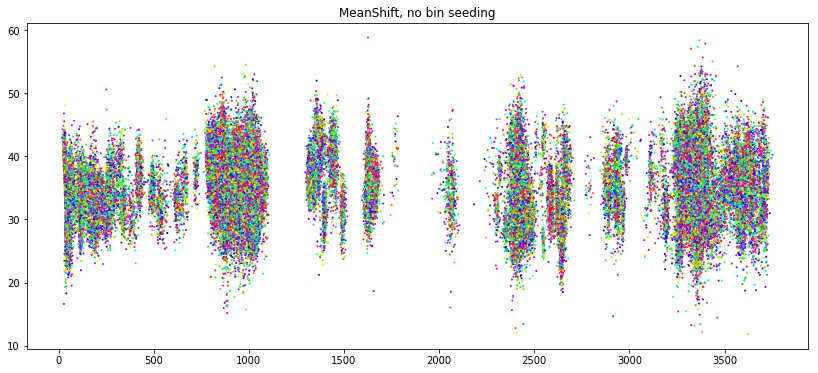

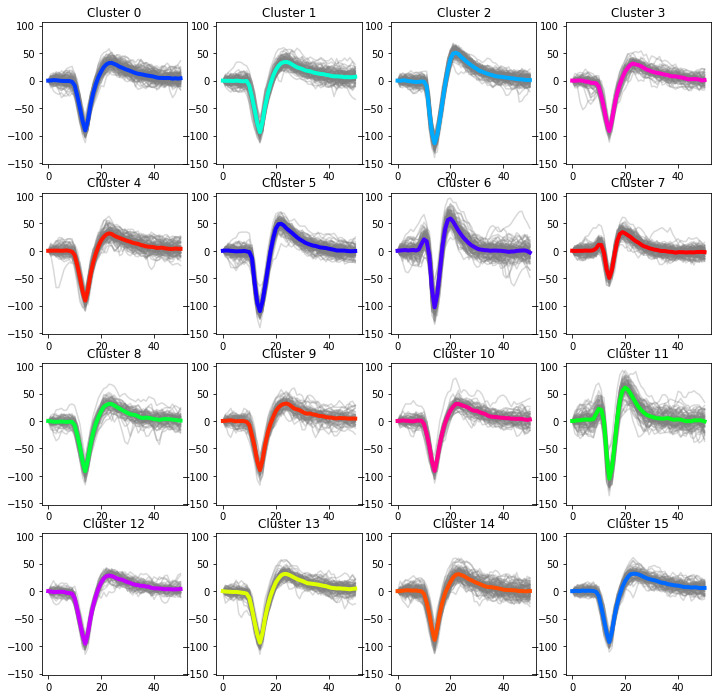

In [29]:
get_cluster(0.5)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    8.6s remaining:   25.9s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    9.6s remaining:    1.9s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    9.8s finished


Number of estimated units: 66089


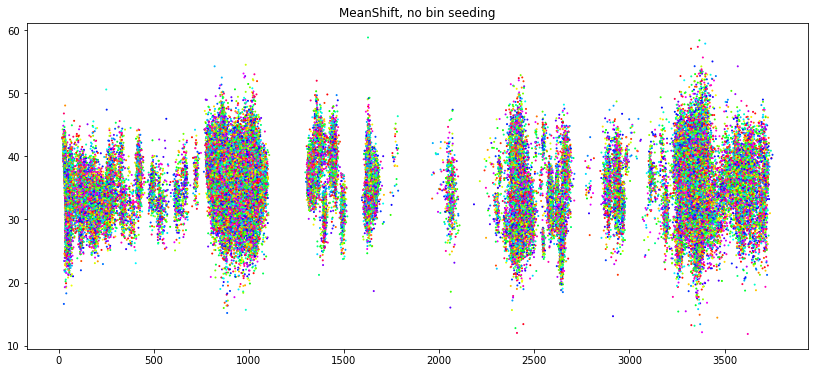

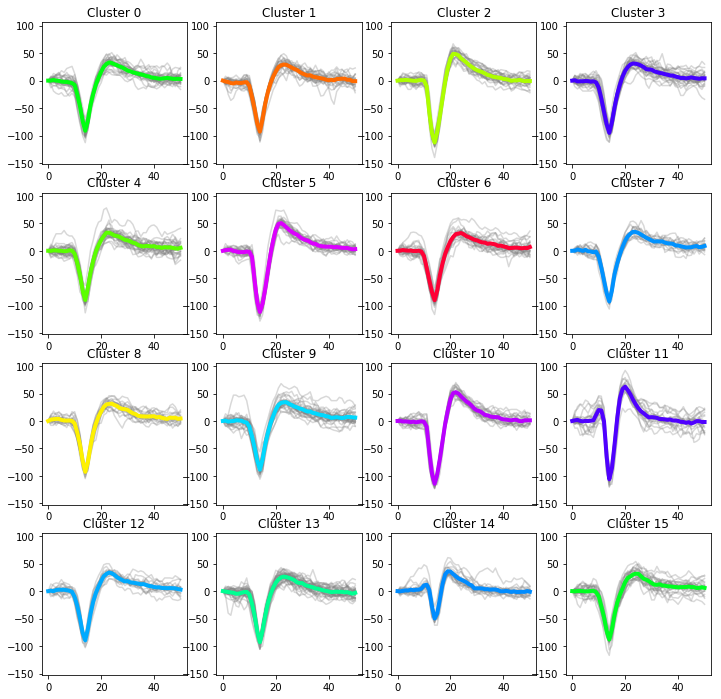

In [30]:
get_cluster(1)

units = range(16)
C.PlotShapes(units)

Clustering...
Clustering 95240 spikes...
number of seeds: 95240
seeds/job: 7937
using 12 cpus


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    6.6s remaining:   19.8s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    7.5s remaining:    1.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    7.7s finished


Number of estimated units: 83572


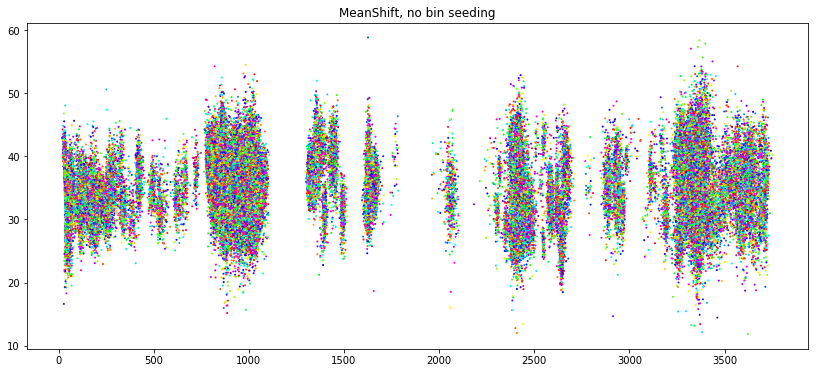

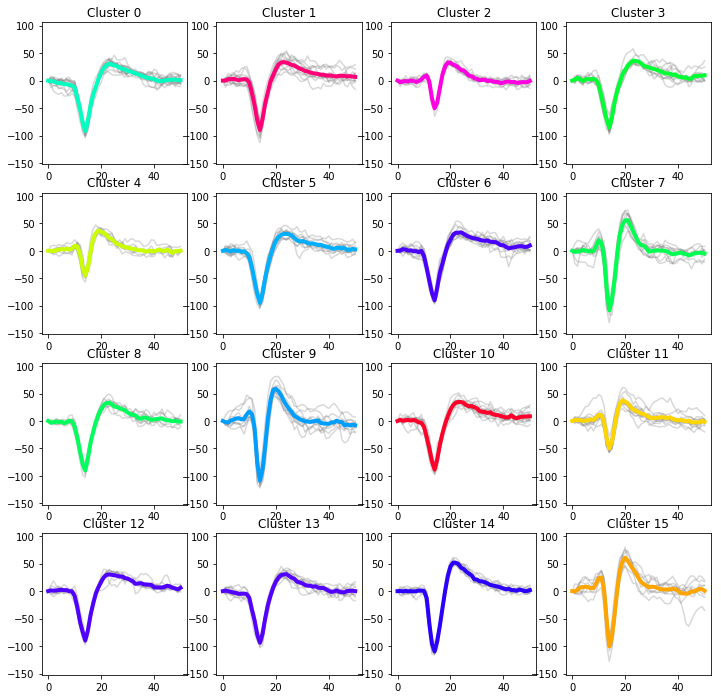

In [31]:
get_cluster(2)

units = range(16)
C.PlotShapes(units)